# HMTK Geological Tools Demonstration

This notepad demonstrates the use of the HMTK geological tools for preparing fault source models for input into OpenQuake

## Construction of the Geological Input File

An active fault model input file contains two sections:

1) A tectonic regionalisation - this can provide a container for a set of properties that may be assigned to multiple faults by virtue of a common tectonic region

2) A set of active faults

#### Tectonic Regionalisation Representation in the Fault Source File

In the tectonic regionalisation information each of the three properties can be represented according to a set of weighted values.
For example, in the case below faults in an arbitrarily named tectonic region (called here "GEM Region 1") will share the same set
of magnitude scaling relations and shear moduli, unless over-written by the specific fault. Those faults assigned to "GEM Region 2"
will have the magnitude scaling relation fixed as WC1994 and the shear modulus of 30 GPa

### Active Fault Model

A set of active faults will be defined with a common ID and name. 

An active fault set containing a single fault is shown below:

#### Fault Geometry Representations - Example 1: Simple Fault

#### Fault Geometry Representations - Example 2: Complex Fault

#### Rupture Properties

The rupture requires characterisation of the rake (using the Aki & Richards 2002 convention), the slip-type, the slip completeness factor
(an integer constraining the quality of the slip information with 1 being the hights quality), the range of slip values and their 
corresponding weights, and the aseismic slip coefficient (the proportion of slip released aseismically, 1.0 - coupling coefficient)

## The Magnitude Frequency Distributions

In [1]:
%load_ext autoreload
%autoreload 2
import warnings; warnings.filterwarnings('ignore')

In [2]:
#Import tools
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from hmtk.plotting.faults.geology_mfd_plot import plot_recurrence_models
from openquake.hazardlib.scalerel.wc1994 import WC1994 
from openquake.hazardlib.scalerel.strasser2010 import StrasserInterface
from openquake.hazardlib.scalerel.strasser2010 import StrasserIntraslab

print("Everything Imported OK!")

Everything Imported OK!


## Epistemic Uncertainty Examples

This example considers the fault defined at the top of the page. This fault defines two values of slip rate and two different magnitude frequency distributions

In [3]:
# Indicate Tectonic Region
tec_reg = "Intraslab" # ASC, Interface, Intraslab

def show_file_contents(filename):
    """
    Shows the file contents
    """
    fid = open(filename, 'r')
    for row in fid.readlines():
        print(row)
    fid.close()

input_file = 'input_data/Simple_Faults_' + tec_reg + '.yml'
show_file_contents(input_file)


#*****************************************************************************

#FAULT FILE IN YAML (Yet Another Markup Language) FORMAT

#*****************************************************************************

#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\





Fault_Model_ID: 003

Fault_Model_Name: Faults Intraslab

Fault_Model:

    - ID: 011

      Tectonic_Region: Subduction Intraslab

      Fault_Name: Mid ELT

      Fault_Geometry: {

          Fault_Typology: Simple,

          # For simple typology, defines the trace in terms of Long., Lat.

          Fault_Trace: [122.397918432333,17.6946955243816,

                        121.635140989681,16.1148984878126],



          # Upper Seismogenic Depth (km)

          Upper_Depth:     50.0,

          # Lower Seismogenic Depth (km)

          Lower_Depth:    100.0,

          Strike: ,

          # Dip (degrees)

          Dip:     58.52634515}

      Rake: 89.0

      Slip_Type: Reverse

    

### Example 1 - Full Enumeration

In this example each individual MFD for each branch is determined. In the resulting file the fault is duplicated n_branches number of times, with the
corresponding MFD multiplied by the end-branch weight

In [4]:
# Import the Parser
from hmtk.parsers.faults.fault_yaml_parser import FaultYmltoSource

# Fault mesh discretization step
mesh_spacing = 1.0 # (km)

# Read in the fault model
reader = FaultYmltoSource(input_file)
fault_model, tectonic_region = reader.read_file(mesh_spacing)

# Construct the fault source model (this is really running the MFD calculation code)
fault_model.build_fault_model()

# Write to an output NRML file
output_file_1 = 'output_data/Simple_Faults_' + tec_reg + '.xml'
fault_model.source_model.serialise_to_nrml(output_file_1)

show_file_contents(output_file_1)

<?xml version="1.0" encoding="utf-8"?>

<nrml

xmlns="http://openquake.org/xmlns/nrml/0.5"

xmlns:gml="http://www.opengis.net/gml"

>

    <sourceModel

    name="Faults Intraslab"

    >

        <sourceGroup

        rup_interdep="indep"

        src_interdep="indep"

        srcs_weights="1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0"

        tectonicRegion="Subduction Intraslab"

        >

            <simpleFaultSource

            id="10_1"

            name="Mid MT1"

            tectonicRegion="Subduction Intraslab"

            >

                <simpleFaultGeometry>

                    <gml:LineString>

                        <gml:posList>

                            119.318447811208 16.0608220862822 119.313245128591 17.5535015581907

                        </gml:posList>

     

### Example 2: Collapsed Branches

In the following example we implement the same model, this time collapsing the branched. This means that the MFD is discretised and the incremental rate
in each magnitude bin is the weighted sum of the rates in that bin from all the end branches of the logic tree.

When collapsing the branches, however, it is necessary to define a single Magnitude Scaling Relation that will need to be assigned to the fault for
use in OpenQuake.

In [5]:
# Read in the fault model
reader = FaultYmltoSource(input_file)
fault_model, tectonic_region = reader.read_file(mesh_spacing)

# Scaling relation for export
MSRDict = {"ASC" : WC1994,
          "Interface" : StrasserInterface,
          "Intraslab" : StrasserIntraslab}

output_msr = MSRDict[tec_reg]()

# Construct the fault source model - collapsing the branches
fault_model.build_fault_model(collapse=True, rendered_msr=output_msr)


# Write to an output NRML file
output_file_2 = 'output_data/Simple_Faults_' + tec_reg + '_Collapsed.xml'
fault_model.source_model.serialise_to_nrml(output_file_2)

show_file_contents(output_file_2)

<?xml version="1.0" encoding="utf-8"?>

<nrml

xmlns="http://openquake.org/xmlns/nrml/0.5"

xmlns:gml="http://www.opengis.net/gml"

>

    <sourceModel

    name="Faults Intraslab"

    >

        <sourceGroup

        rup_interdep="indep"

        src_interdep="indep"

        srcs_weights="1.0 1.0 1.0 1.0 1.0 1.0"

        tectonicRegion="Subduction Intraslab"

        >

            <simpleFaultSource

            id="10_1"

            name="Mid MT1"

            tectonicRegion="Subduction Intraslab"

            >

                <simpleFaultGeometry>

                    <gml:LineString>

                        <gml:posList>

                            119.318447811208 16.0608220862822 119.313245128591 17.5535015581907

                        </gml:posList>

                    </gml:LineString>

                    <dip>

                        47.71243516

                    </dip>

                    <upperSeismoDepth>

                        50.0

                    

### Example 3: Fault Plotting

In the last example we will take some real fault data from the Gulf of Corinth

In [6]:
# For plotting
from hmtk.plotting.mapping import HMTKBaseMap
corinth_fault_file = 'input_data/Simple_Faults_' + tec_reg + '.yml'

reader = FaultYmltoSource(corinth_fault_file)
corinth_faults, tectonic_region = reader.read_file(mesh_spacing)

print("   ID                         Name   Area (km^2)")
for i, fault in enumerate(corinth_faults.faults):
    print("%2g    %s    %25s    %10.3f" % (i, fault.id, fault.name, fault.area))

   ID                         Name   Area (km^2)
 0    9                      Mid ELT     11344.093
 1    10                      Mid MT1     11218.197
 2    11                      Mid MT2     14568.172
 3    12                     Deep MT2     40117.008
 4    13                      Mid MT3     10919.657
 5    14                     Deep MT3     38323.492


For convenience we will collapse the branches again

In [7]:
# Scaling relation for export
MSRDict = {"ASC" : WC1994,
          "Interface" : StrasserInterface,
          "Intraslab" : StrasserIntraslab}

output_msr = MSRDict[tec_reg]()


# Construct the fault source model - collapsing the branches
corinth_faults.build_fault_model(collapse=True, rendered_msr=output_msr)

Let's take a look at the fault sources

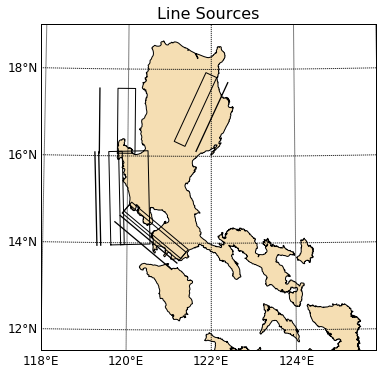

In [8]:
map_config = {'min_lon': 118.0, 'max_lon': 126.0,
             'min_lat': 11.5, 'max_lat': 19.0, 'resolution':'h'} # LUZON

# map_config = {'min_lon': 120.0, 'max_lon': 127.75,
#              'min_lat': 7.0, 'max_lat': 13.5, 'resolution':'h'} # VISAYAS

#map_config = {'min_lon': 120.5, 'max_lon': 128.5,
#              'min_lat': 6.5, 'max_lat': 12.0, 'resolution':'h'} # MINDANAO

# map_config = {'min_lon': 118.0, 'max_lon': 127.5,
#               'min_lat': 9.0, 'max_lat': 18.0, 'resolution':'h'}

# Map the Source
src_basemap = HMTKBaseMap(map_config, "Line Sources")
src_basemap.add_source_model(corinth_faults.source_model)

# ----- STOP HERE -----

The following examples refer to a fault with the following properties:

Length (Along-strike) = 100 km,
Width (Down-Dip) = 20 km,
Slip = 10.0 mm/yr,
Rake = 0. (Strike Slip),
Magnitude Scaling Relation = Wells & Coppersmith (1994),
Shear Modulus = 30.0 GPa

In [ ]:
# Set up fault parameters
slip = 10.0  # Slip rate in mm/yr

# Area = along-strike length (km) * down-dip with (km)
area = 100.0 * 20.0

# Rake = 0.
rake = 0.

# Magnitude Scaling Relation
msr = WC1994()

### Anderson & Luco (Arbitrary)

This describes a set of distributons where the maximum magnitude is assumed to rupture the whole fault surface

In [ ]:
#Magnitude Frequency Distribution Example

anderson_luco_config1 = {'Model_Name': 'AndersonLucoArbitrary',
                         'Model_Type': 'First',
                         'Model_Weight': 1.0,  # Weight is a required key - normally weights should sum to 1.0 - current example is simply illustrative! 
                         'MFD_spacing': 0.1,
                         'Maximum_Magnitude': None,
                         'Minimum_Magnitude': 4.5,
                         'b_value': [0.8, 0.05]}
anderson_luco_config2 = {'Model_Name': 'AndersonLucoArbitrary',
                         'Model_Type': 'Second',
                         'Model_Weight': 1.0,
                         'MFD_spacing': 0.1,
                         'Maximum_Magnitude': None,
                         'Minimum_Magnitude': 4.5,
                         'b_value': [0.8, 0.05]}
anderson_luco_config3 = {'Model_Name': 'AndersonLucoArbitrary',
                         'Model_Type': 'Third',
                         'Model_Weight': 1.0,   
                         'MFD_spacing': 0.1,
                         'Maximum_Magnitude': None,
                         'Minimum_Magnitude': 4.5,
                         'b_value': [0.8, 0.05]}
# Create a list of the configurations
anderson_luco_arb = [anderson_luco_config1, anderson_luco_config2, anderson_luco_config3]

# View the corresponding magnitude recurrence model
plot_recurrence_models(anderson_luco_arb, area, slip, msr, rake, msr_sigma=0.0)

### Anderson & Luco (Area - MMax)

This describes a set of distributons where the maximum rupture extent is limited to only part of the fault surface

In [ ]:
anderson_luco_config1 = {'Model_Name': 'AndersonLucoAreaMmax',
                         'Model_Type': 'First',
                         'Model_Weight': 1.0,  # Weight is a required key - normally weights should sum to 1.0 - current example is simply illustrative! 
                         'MFD_spacing': 0.1,
                         'Maximum_Magnitude': None,
                         'Minimum_Magnitude': 4.5,
                         'b_value': [0.8, 0.05]}
anderson_luco_config2 = {'Model_Name': 'AndersonLucoAreaMmax',
                         'Model_Type': 'Second',
                         'Model_Weight': 1.0,
                         'MFD_spacing': 0.1,
                         'Maximum_Magnitude': None,
                         'Minimum_Magnitude': 4.5,
                         'b_value': [0.8, 0.05]}
anderson_luco_config3 = {'Model_Name': 'AndersonLucoAreaMmax',
                         'Model_Type': 'Third',
                         'Model_Weight': 1.0,   
                         'MFD_spacing': 0.1,
                         'Maximum_Magnitude': None,
                         'Minimum_Magnitude': 4.5,
                         'b_value': [0.8, 0.05]}

# For these models a displacement to length ratio is needed
disp_length_ratio = 1.25E-5

# Create a list of the configurations
anderson_luco_area_mmax = [anderson_luco_config1, anderson_luco_config2, anderson_luco_config3]

# View the corresponding magnitude recurrence model
plot_recurrence_models(anderson_luco_area_mmax, area, slip, msr, rake, msr_sigma=0.0)


### Characteristic Earthquake

The following example illustrates a "Characteristic" Model, represented by a Truncated Gaussian Distribution

In [ ]:
characteristic = [{'Model_Name': 'Characteristic',
                   'MFD_spacing': 0.05,
                   'Model_Weight': 1.0,
                   'Maximum_Magnitude': None,
                   'Sigma': 0.15,  # Standard Deviation of Distribution (in Magnitude Units) - omit for fixed value
                   'Lower_Bound': -3.0,   # Bounds of the distribution correspond to the number of sigma for truncation
                   'Upper_Bound': 3.0}]

# View the corresponding magnitude recurrence model
plot_recurrence_models(characteristic, area, slip, msr, rake, msr_sigma=0.0)

### Youngs & Coppersmith (1985) Models

The following describes the recurrence from two distributions presented by Youngs & Coppersmith (1985): 1) Exponential Distribution, 2) Hybrid Exponential-Characteristic Distribution

In [ ]:
exponential = {'Model_Name': 'YoungsCoppersmithExponential',
               'MFD_spacing': 0.1,
               'Maximum_Magnitude': None,
               'Maximum_Magnitude_Uncertainty': None,
               'Minimum_Magnitude': 5.0,
               'Model_Weight': 1.0,
               'b_value': [0.8, 0.1]}

hybrid = {'Model_Name': 'YoungsCoppersmithCharacteristic',
          'MFD_spacing': 0.1,
          'Maximum_Magnitude': None,
          'Maximum_Magnitude_Uncertainty': None,
          'Minimum_Magnitude': 5.0,
          'Model_Weight': 1.0,
          'b_value': [0.8, 0.1],
          'delta_m': None}

youngs_coppersmith = [exponential, hybrid]

# View the corresponding magnitude recurrence model
plot_recurrence_models(youngs_coppersmith, area, slip, msr, rake, msr_sigma=0.0)


##### Find and Show Events within 30 km of the Xylocastro Fault

In [ ]:
from hmtk.parsers.catalogue.csv_catalogue_parser import CsvCatalogueParser
from hmtk.seismicity.selector import CatalogueSelector

# Load in the catalogue
catalogue_file = "input_data/Aegean_ExtendedCat1.csv"
parser = CsvCatalogueParser(catalogue_file)
catalogue = parser.read_file()
print catalogue.get_number_events()

#Create a selector object
selector = CatalogueSelector(catalogue)
xylocastro_fault = corinth_faults.faults[15]

# Select earthquakes within 30 km (rupture distance) of the fault
xylocastro_fault.select_catalogue(selector, 30.0, distance_metric="rupture")
print "%g events with 30 km of the Xylocastro Fault" % xylocastro_fault.catalogue.get_number_events()

Show the events

In [ ]:
map_config = {'min_lon': 20.9, 'max_lon': 24.0,
              'min_lat': 37.5, 'max_lat': 39.0, 'resolution':'h'}

# Map the Source
src_basemap = HMTKBaseMap(map_config, "Gulf of Corinth Faults")
src_basemap.add_source_model(corinth_faults.source_model, overlay=True)
src_basemap.add_catalogue(xylocastro_fault.catalogue)

### Export output to XML File

In [ ]:
corinth_output_file = "output_data/New_Gulf_Of_Corinth_Faults.xml"
corinth_faults.source_model.serialise_to_nrml(corinth_output_file)
show_file_contents(corinth_output_file)